In [ ]:
!pip3 install ipywidgets matplotlib opencv-python pandas torch torchvision tqdm

In [30]:
import cv2
import os.path
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms

# Data set and data loaders
The [Chinese MNIST dataset](https://www.kaggle.com/datasets/gpreda/chinese-mnist) is a small dataset of 15,000 images. Each image represents one of 15 simplified Chinese characters, written 10 times, by 100 volunteers. The characters represent the numbers one through nine, as well as one hundred, one thousand, ten thousand, and 100 million. 

In [3]:
CSV_PATH = './data/chinese_mnist.csv'
IMG_DIR = './data/data'

# Build and save image file names corresponding to each character record
csv = pd.read_csv(CSV_PATH)
csv['file'] = csv[['suite_id', 'sample_id', 'code']].apply(
    lambda x: f'input_{x["suite_id"]}_{x["sample_id"]}_{x["code"]}.jpg',
    axis=1
)
csv.head()

,suite_id,sample_id,code,value,character,file
0,1,1,10,9,九,input_1_1_10.jpg
1,1,10,10,9,九,input_1_10_10.jpg
2,1,2,10,9,九,input_1_2_10.jpg
3,1,3,10,9,九,input_1_3_10.jpg
4,1,4,10,9,九,input_1_4_10.jpg


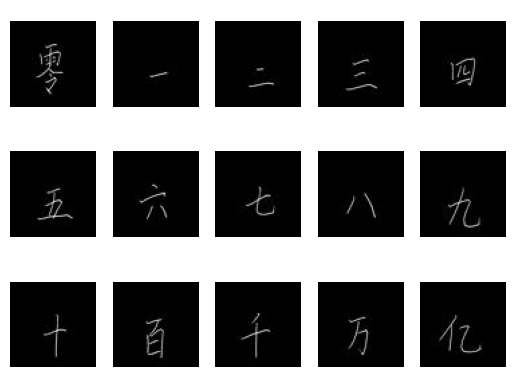

In [4]:

# Display an example of each possible character, all from the same participant
for i in range(15):
    image = cv2.imread(f'{IMG_DIR}/input_1_1_{i + 1}.jpg')
    plt.axis('off')
    plt.subplot(3, 5, i + 1)
    plt.imshow(image)

plt.axis('off')
plt.show()

In [58]:
# Some helpful util functions

CODE_TO_CHAR = {}
CODE_TO_VAL = {}

for i, row in csv.iterrows():
    code = row['code']
    char = row['character']
    val = row['value']
    # Adjust to 0-indexed because that's what we use for data labels
    CODE_TO_CHAR[code - 1] = char
    CODE_TO_VAL[code - 1] = val

def get_char_from_code(code: int):
    return CODE_TO_CHAR[code]

def get_value_from_code(code: int):
    return CODE_TO_VAL[code]

def read_image_to_tensor(img_path: str):
    image = cv2.imread(img_path).astype('float32')
    image = cv2.resize(image, (64, 64))
    # (64, 64, 3) -> (3, 64, 64)
    image = image.transpose(2, 0, 1)
    return torch.from_numpy(image)

In [22]:
class ChineseMNISTDataset(Dataset):
    def __init__(self):
        self.labels = csv

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx: int):
        filename = self.labels.loc[idx, 'file']
        path = os.path.join(IMG_DIR, str(filename))
        image = read_image_to_tensor(path)
        
        # "code" is 1-indexed, but we need 0-indexed to correctly map to target classes
        label = self.labels.loc[idx, 'code'].astype(int) - 1
        return image, label
    
dataset = ChineseMNISTDataset()

In [6]:
# Examine a single image
image, label = dataset[0]
print(label, image.shape)

9 torch.Size([3, 64, 64])


In [7]:
# Break dataset into separate groups for training and testing
train_set, test_set = random_split(dataset, [12500, 2500])

train_loader = DataLoader(dataset=train_set, batch_size=50, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=50)

# Data loader length should be equal to its dataset length / batch size
len(train_loader), len(test_loader)

(250, 50)

# Model

In [8]:
INPUT_SIZE = 3 * 64 * 64
OUTPUT_SIZE = 15

class ImageClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Halving inputs seems to work?
        self.Matrix1 = nn.Linear(INPUT_SIZE, 6144)
        self.Matrix2 = nn.Linear(6144, 3072)
        self.Matrix3 = nn.Linear(3072, 1536)
        self.Matrix4 = nn.Linear(1536, 768)
        self.Matrix5 = nn.Linear(768, OUTPUT_SIZE)

    def forward(self, x):
        # x.shape = torch.Size([<batch_size>, 3, 64, 64])
        out = x.reshape(-1, INPUT_SIZE)
        out = self.Matrix1(out)
        out = self.Matrix2(F.relu(out))
        out = self.Matrix3(F.relu(out))
        out = self.Matrix4(F.relu(out))
        out = self.Matrix5(F.relu(out))
        return out

    
model = ImageClassifier()

# Training

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [10]:
all_training_losses = []

def train_model(epochs=5):
    model.train()
    num_batches = len(train_loader)
    
    for epoch in range(epochs):
        epoch_losses = []

        for idx, (data, target) in enumerate(tqdm(train_loader, desc=f'[Training] Epoch {epoch + 1}')):
            # Zero the gradients to prevent accumulation
            optimizer.zero_grad()
            
            # Forward pass: compute predicted outputs
            output = model(data)
            
            # Compute the loss
            loss = criterion(output, target)
            
            # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            
            # Perform a single optimization step (parameter update)
            optimizer.step()
            
            epoch_losses.append(loss.item())
            all_training_losses.append((epoch + idx / num_batches, loss.item()))

        epoch_avg_loss = sum(epoch_losses) / num_batches
        print(f'[Training] Epoch {epoch + 1}, Average loss: {epoch_avg_loss:.4f}')
        
train_model()

[Training] Epoch 1:   0%|          | 0/250 [00:00<?, ?it/s]

[Training] Epoch 1, Average loss: 1.7825


[Training] Epoch 2:   0%|          | 0/250 [00:00<?, ?it/s]

[Training] Epoch 2, Average loss: 0.7755


[Training] Epoch 3:   0%|          | 0/250 [00:00<?, ?it/s]

[Training] Epoch 3, Average loss: 0.3653


[Training] Epoch 4:   0%|          | 0/250 [00:00<?, ?it/s]

[Training] Epoch 4, Average loss: 0.2337


[Training] Epoch 5:   0%|          | 0/250 [00:00<?, ?it/s]

[Training] Epoch 5, Average loss: 0.0848


Text(0, 0.5, 'Cross entropy loss')

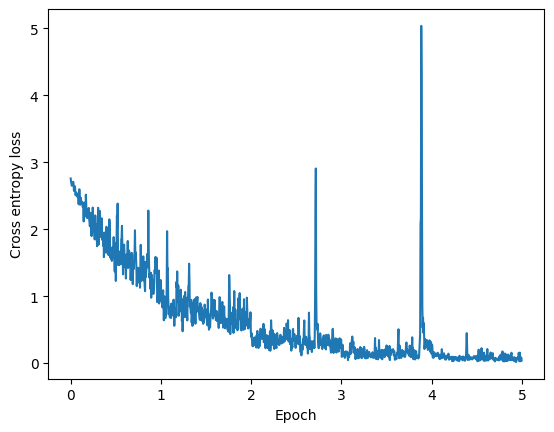

In [11]:
epochs, losses = zip(*all_training_losses)
plt.plot(epochs, losses)
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")

In [12]:
def evaluate_model():
    model.eval()
    
    correct = 0
    total = 0
    
    # Disable gradient computation
    with torch.no_grad():
        for data, target in tqdm(test_loader):
            # Forward pass: compute predicted outputs
            output = model(data)
            
            # Get the predicted class
            _, predicted = torch.max(output.data, 1)
            
            # Update the number of correct predictions and total samples
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    # Calculate accuracy
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')
    return accuracy

evaluate_model()

  0%|          | 0/50 [00:00<?, ?it/s]

Accuracy: 85.20%


85.2

In [28]:
MODEL_PATH = './model'

if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

torch.save(model.state_dict(), os.path.join(MODEL_PATH, 'checkpoint.pt'))

# Testing


In [52]:
def test_model(img_path: str):
    model.eval()

    image = read_image_to_tensor(img_path)
    # Unsqueeze to go from (3, 64, 64) -> (1, 3, 64, 64) to appease model
    # (1 representing batch size for a single image)
    image = image.unsqueeze(0)

    with torch.no_grad():
        output = model(image)
        
        # Get top 3 predicted matches
        _, predicted = torch.topk(output.data, 3, 1)
        # tensor([[x, y, z]]) -> [x, y, z]
        predicted_arr = predicted.detach().tolist()[0]
        results = [
            { "code": code, "character": get_char_from_code(code), "value": get_value_from_code(code)}
            for code in predicted_arr
        ]

        print(f'The possible matches for {img_path} are {results}')
        return results

test_model('./test/eight.png')


The possible matches for ./test/eight.png are [{'code': 8, 'character': '八', 'value': 8}, {'code': 2, 'character': '二', 'value': 2}, {'code': 6, 'character': '六', 'value': 6}]


[{'code': 8, 'character': '八', 'value': 8},
 {'code': 2, 'character': '二', 'value': 2},
 {'code': 6, 'character': '六', 'value': 6}]

In [53]:
from PIL import Image

def test_model_pil(img_path: str):
    model.eval()

    image = Image.open(img_path).convert('RGB')
    t = transforms.Compose([
        transforms.PILToTensor(),
        transforms.Resize(64),
        lambda x: x * 255. # Force image data values to float32, not uint8
    ])
    image = t(image)

    assert isinstance(image, torch.Tensor)
    image = image.unsqueeze(0)

    with torch.no_grad():
        output = model(image)
        
        # Get top 3 predicted matches
        _, predicted = torch.topk(output.data, 3, 1)
        # tensor([[x, y, z]]) -> [x, y, z]
        predicted_arr = predicted.detach().tolist()[0]
        results = [
            { "code": code, "character": get_char_from_code(code), "value": get_value_from_code(code)}
            for code in predicted_arr
        ]

        print(f'The possible matches for {img_path} are {results}')
        return results

test_model_pil('./test/eight.png')

The possible matches for ./test/eight.png are [{'character': '八', 'value': 8}, {'character': '亿', 'value': 100000000}, {'character': '九', 'value': 9}]


[{'character': '八', 'value': 8},
 {'character': '亿', 'value': 100000000},
 {'character': '九', 'value': 9}]